# BRISMF

We first install the necessary packages.

In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357289 sha256=ef4c2369be5278197dede32066538c59c0f3002f90ebde73e7c283223146953d
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np

## Temporal Splitting on Newest Data

We split the data temporally. In other words, we first find the 180000 most recent ratings. We then reserve the newest 20000 of the 180000 ratings as the test set. Among the remaining 160000, we randomly split them into a training set of 80000 that is to be used for each of the individual models, and another training set of 80000 that is to be used for the ensemble model.

In [ ]:
full = pd.read_csv('test.csv').drop(columns=['Unnamed: 0'])[-180000:] # despite its name, test.csv actually contains the 1000000 newest ratings sorted by rating date from the oldest to the newest
full # full contains the 180000 newest ratings

,movie_id,user_id,rating,date,Year,Title
20000,17147,427460,4,2005-12-29,1996,She's the One
20001,4353,1605111,5,2005-12-29,2002,Curb Your Enthusiasm: Season 3
20002,3923,13949,3,2005-12-29,1997,Beverly Hills Ninja
20003,6874,200779,3,2005-12-29,2003,The Cooler
20004,12582,851475,4,2005-12-29,2003,Mystic River
...,...,...,...,...,...,...
199995,8993,2183787,4,2005-12-31,2005,Family Guy Presents: Stewie Griffin: The Untol...
199996,7430,258170,4,2005-12-31,2001,Six Feet Under: Season 1
199997,8467,1534359,5,2005-12-31,1996,Eraser
199998,10168,2543295,2,2005-12-31,2003,The League of Extraordinary Gentlemen


In [ ]:
train_full = full[:160000] # the 160000 ratings used in training
train_full

,movie_id,user_id,rating,date,Year,Title
20000,17147,427460,4,2005-12-29,1996,She's the One
20001,4353,1605111,5,2005-12-29,2002,Curb Your Enthusiasm: Season 3
20002,3923,13949,3,2005-12-29,1997,Beverly Hills Ninja
20003,6874,200779,3,2005-12-29,2003,The Cooler
20004,12582,851475,4,2005-12-29,2003,Mystic River
...,...,...,...,...,...,...
179995,13629,1318034,4,2005-12-31,1951,Alice in Wonderland
179996,17324,1719503,4,2005-12-31,2005,Hitch
179997,17324,22846,5,2005-12-31,2005,Hitch
179998,3860,1799620,2,2005-12-31,2003,Bruce Almighty


In [ ]:
test = full[-20000:] # the 20000 ratings used for testing
test

,movie_id,user_id,rating,date,Year,Title
180000,16445,1250138,2,2005-12-31,2003,"House of 1,000 Corpses"
180001,6850,714682,1,2005-12-31,2005,Lords of Dogtown
180002,3441,859907,2,2005-12-31,2005,Kicking & Screaming
180003,10748,2373473,3,2005-12-31,1987,Hamburger Hill
180004,5496,1678873,2,2005-12-31,2004,"I, Robot"
...,...,...,...,...,...,...
199995,8993,2183787,4,2005-12-31,2005,Family Guy Presents: Stewie Griffin: The Untol...
199996,7430,258170,4,2005-12-31,2001,Six Feet Under: Season 1
199997,8467,1534359,5,2005-12-31,1996,Eraser
199998,10168,2543295,2,2005-12-31,2003,The League of Extraordinary Gentlemen


In [ ]:
from sklearn.model_selection import train_test_split

# Randomly split the 160000 training data into a set used for individual models and another set used for the ensemble model
train, ensemble_train = train_test_split(train_full, test_size=0.5, random_state=42)
print(len(train))
print(len(ensemble_train))

80000
80000


In [ ]:
train # "train" is used for training each of the individual models

,movie_id,user_id,rating,date,Year,Title
72231,15582,1386463,3,2005-12-29,2002,Sweet Home Alabama
75364,9087,1380250,3,2005-12-29,1992,Hero
53303,16793,2188505,3,2005-12-29,1973,The Exorcist
47730,5762,1109774,2,2005-12-29,2000,Almost Famous
136959,10072,1067658,3,2005-12-30,2004,Prime Suspect 6
...,...,...,...,...,...,...
139879,2457,71480,2,2005-12-30,2004,A Cinderella Story
123694,11089,2300374,4,2005-12-30,2001,"Monsters, Inc."
151932,6134,2610903,4,2005-12-30,2004,Collateral
166867,5762,1784540,4,2005-12-31,2000,Almost Famous


In [ ]:
ensemble_train # "ensemble_train" is used for training the ensemble model

,movie_id,user_id,rating,date,Year,Title
140476,17574,2475007,5,2005-12-30,1996,Eye for an Eye
52693,14312,583131,4,2005-12-29,1993,Jurassic Park
99958,10747,1795937,4,2005-12-30,1987,Can't Buy Me Love
96366,4306,617075,4,2005-12-30,1999,The Sixth Sense
102343,4302,1999688,5,2005-12-30,1982,An Officer and a Gentleman
...,...,...,...,...,...,...
141665,191,1965579,5,2005-12-30,2003,X2: X-Men United
142463,1104,1498526,3,2005-12-30,1983,Krull
68961,2153,1916203,3,2005-12-29,1993,Free Willy
151628,15788,1988882,3,2005-12-30,2003,Matchstick Men


In [ ]:
len(train['movie_id'].unique()) # number of movies in training set for individual models

8070

In [ ]:
len(train['user_id'].unique()) # number of users in training set for individual models

16062

#### Further Split of Train and Validation Sets

We use the validation set approach to select the hyperparameters for each of the individual models. In this case, we further divide the training set for the individual models into a non-validation set of size 64000 (used for training in the validation set approach) and a validation set of size 16000 (used for testing in the validation set approach).

In [ ]:
non_validation = train[:64000]
non_validation # used for training when selecting hyperparameters

,movie_id,user_id,rating,date,Year,Title
72231,15582,1386463,3,2005-12-29,2002,Sweet Home Alabama
75364,9087,1380250,3,2005-12-29,1992,Hero
53303,16793,2188505,3,2005-12-29,1973,The Exorcist
47730,5762,1109774,2,2005-12-29,2000,Almost Famous
136959,10072,1067658,3,2005-12-30,2004,Prime Suspect 6
...,...,...,...,...,...,...
30015,7879,40960,3,2005-12-29,2002,Super Troopers
80369,6274,240400,3,2005-12-30,1990,The Hunt for Red October
55706,16796,2026731,5,2005-12-29,2001,Brian's Song
45223,357,649154,4,2005-12-29,2003,House of Sand and Fog


In [ ]:
validation = train[64000:]
validation # used for testing when selecting hyperparameters

,movie_id,user_id,rating,date,Year,Title
31584,6833,793778,5,2005-12-29,1995,Billy Madison
161832,16784,1663055,3,2005-12-31,2005,The Sisterhood of the Traveling Pants
63677,5496,2397099,4,2005-12-29,2004,"I, Robot"
70478,10906,1208781,2,2005-12-29,2004,Cellular
148826,17154,1489446,5,2005-12-30,1993,Philadelphia
...,...,...,...,...,...,...
139879,2457,71480,2,2005-12-30,2004,A Cinderella Story
123694,11089,2300374,4,2005-12-30,2001,"Monsters, Inc."
151932,6134,2610903,4,2005-12-30,2004,Collateral
166867,5762,1784540,4,2005-12-31,2000,Almost Famous


## compute_rmse Function

We define a compute_rmse function that takes in the predicted output and actual output, so that we can conveniently compute the RMSE of our predictions.

In [ ]:
# Takes in two NumPy arrays
def compute_rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) * (predicted - actual)))

## Model Training and Testing

We implement the BRISMF algorithm in the BRISMF class below.

In [ ]:
from sklearn.base import BaseEstimator
from scipy.sparse import csr_matrix

class BRISMF(BaseEstimator):
    def __init__(self, K=5, lr_pb=0.0003, lr_p=0.0003, lr_qb=0.0003, lr_q=0.0003,
                 p_pb=0.01, p_p=0.01, p_qb=0.01, p_q=0.01, num_to_stop=2, epochs=10):
        # Initialize instance variables
        self.N = 0
        self.M = 0
        self.K = K
        self.lr_pb = lr_pb
        self.lr_p = lr_p
        self.lr_qb = lr_qb
        self.lr_q = lr_q
        self.p_pb = p_pb
        self.p_p = p_p
        self.p_qb = p_qb
        self.p_q = p_q
        self.num_to_stop = num_to_stop
        self.epochs = epochs
        self.P = None
        self.Q = None
        self.user_map = None
        self.movie_map = None
        self.global_mean = 0
        self.user_means = []
        self.movie_means = []


    def fit(self, X, y):
        # Map user_id and movie_id to indices
        self.global_mean = np.mean(y)
        users, user_map = np.unique(X['user_id'], return_inverse=True)
        movies, movie_map = np.unique(X['movie_id'], return_inverse=True)
        self.user_map = {u: i for i, u in enumerate(users)}
        self.movie_map = {i: j for j, i in enumerate(movies)}
        self.N = len(users)
        self.M = len(movies)
        self.P = self.generate_P0(self.N, self.K)
        self.Q = self.generate_Q0(self.K, self.M)

        # Compute mean rating for each user and each movie, respectively
        for u in users:
            self.user_means.append(np.mean(y[X['user_id'] == u]))
        for m in movies:
            self.movie_means.append(np.mean(y[X['movie_id'] == m]))
        self.user_means = np.array(self.user_means)
        self.movie_means = np.array(self.movie_means)

        # Standardize the training ratings by subtracting the average of their respective user mean rating and movie mean rating from them
        y_user_mean = np.zeros(X.shape[0])
        y_movie_mean = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            user_mean = self.user_means[self.user_map[X.iloc[i][1]]]
            movie_mean = self.movie_means[self.movie_map[X.iloc[i][0]]]
            y_user_mean[i] = user_mean
            y_movie_mean[i] = movie_mean
        y_standardized = y - 0.5 * y_user_mean - 0.5 * y_movie_mean

        # Create a sparse matrix of the standardized training ratings to save memory
        ratings = csr_matrix((y_standardized, (user_map, movie_map)), shape=(self.N, self.M))

        # Main loop
        num_epochs = 0
        best_rmse = np.inf
        while (num_epochs < self.epochs):
            for u, i, r in zip(*ratings.nonzero(), ratings.data):
                # Compute error
                pred = np.dot(self.P[u], self.Q[:, i])
                e = r - pred

                # Gradient updates
                if (u == 1):
                    self.P[u] += self.lr_pb * (e * self.Q[:, i] - self.p_pb * self.P[u])
                elif (u > 1):
                    self.P[u] += self.lr_p * (e * self.Q[:, i] - self.p_p * self.P[u])
                if (i == 0):
                    self.Q[:, i] += self.lr_qb * (e * self.P[u] - self.p_qb * self.Q[:, i])
                elif (i > 1):
                    self.Q[:, i] += self.lr_q * (e * self.P[u] - self.p_q * self.Q[:, i])
            num_epochs += 1

        # Logging
        print("Training finished with", num_epochs, "epochs and a final RMSE of", best_rmse)
        return self


    # Returns a list
    def predict(self, X):
        output = []

        # Get the corresponding index for each user id and each movie_id
        user_indices = X['user_id'].unique()
        movie_indices = X['movie_id'].unique()

        # Loop through the data to predict each data point
        for c in range(0, X.shape[0]):
            u_raw = X.iloc[c][1] # Get the current user_id
            i_raw = X.iloc[c][0] # Get the current movie_id

            # If the both current user and movie exist in training data, the prediction will be the dot product of the u-th row in P
            # and the i-th column in Q, plus the average of the user mean rating and the movie mean rating
            if (u_raw in self.user_map and i_raw in self.movie_map):
                u = self.user_map[X.iloc[c][1]] # Get the index of the user
                i = self.movie_map[X.iloc[c][0]] # Get the index of the movie
                r_hat = np.dot(self.P[u], self.Q[:,i])
                output.append(r_hat + 0.5 * self.movie_means[i] + 0.5 * self.user_means[u])
            # If the curent user, but not the curent movie, exists in training data, we use the user mean rating as the prediction
            elif (u_raw in self.user_map):
                u = self.user_map[X.iloc[c][1]]
                output.append(self.user_means[u])
            # If the current movie, but not the current user, exists in training darta, we use the movie mean rating as the prediction
            elif (i_raw in self.movie_map):
                i = self.movie_map[X.iloc[c][0]]
                output.append(self.movie_means[i])
            # If neither the current user nor the current movie exists in training data, we use the global mean rating as the prediction
            else:
                output.append(self.global_mean)

        return np.array(output)


    def get_P(self):
        return self.P


    def get_Q(self):
        return self.Q


    def generate_P0(self, N, K):
        output = 0.000001 * np.random.rand(N, K)
        output[:,0] = 1
        return output


    def generate_Q0(self, K, M):
        output = 0.000001 * np.random.rand(K, M)
        output[1,:] = 1
        return output


    def compute_rmse(self, ratings):
        rows, cols = ratings.nonzero()
        predictions = np.sum(self.P[rows] * self.Q[:, cols].T, axis=1)
        errors = ratings.data - predictions
        return np.sqrt(np.mean(errors ** 2))


    # Define get_params method to return the model's hyperparameters
    def get_params(self, deep=True):
        return {
            'K': self.K,
            'lr_pb': self.lr_pb,
            'lr_p': self.lr_p,
            'lr_qb': self.lr_qb,
            'lr_q': self.lr_q,
            'p_pb': self.p_pb,
            'p_p': self.p_p,
            'p_qb': self.p_qb,
            'p_q': self.p_q,
            'num_to_stop': self.num_to_stop,
        }


    # Define set_params method to set hyperparameters
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

Next, we select the hyperparameters using the validation set approach. Note that due to limited computing power, we only select $K$, $\eta^p$, $\eta^q$, $\lambda^p$, and $\lambda^q$.

In [ ]:
best_rmse = np.inf
best_params = None

# Candidate hyperparameter values
K_list = [10, 100, 1000]
lr_p_list = [0.00003, 0.0003]
lr_q_list = [0.00003, 0.0003]
p_p_list = [0.001, 0.01]
p_q_list = [0.001, 0.01]

# Main loop
for K in K_list:
  for lr_p in lr_p_list:
    for lr_q in lr_q_list:
      for p_p in p_p_list:
        for p_q in p_q_list:
          model = BRISMF(K=K, lr_p=lr_p, lr_q=lr_q, p_p=p_p, p_q=p_q)
          model.fit(non_validation.drop(columns=['rating']), non_validation['rating'])
          rmse = compute_rmse(validation['rating'].to_numpy(), model.predict(validation))
          if (rmse < best_rmse):
            best_rmse = rmse
            best_params = [K, lr_p, lr_q, p_p, p_q]

We finaly selected $K=10$, $\eta^p=0.00003$, $\eta^q=0.00003$, $\lambda^p=0.01$, and $\lambda^q=0.01$.

In [ ]:
best_rmse, best_params

(0.9618411476787072, [10, 3e-05, 3e-05, 0.01, 0.01])

We train a BRISMF model using the hyperparameters selected above as well as $\eta^{pb}=\eta^{qb}=0.0003$ and $\lambda^{pb}=\lambda^{qb}=0.01$, and then evaluate its test RMSE.

In [ ]:
# Model training
brismf_100000 = BRISMF(K=10, epochs=10, lr_p=3e-05, lr_q=3e-05, p_p=0.01, p_q=0.01)
brismf_100000.fit(train.drop(columns=['rating']), train['rating'])

<ipython-input-32-56907c0bdda9>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_mean = self.user_means[self.user_map[X.iloc[i][1]]]
<ipython-input-32-56907c0bdda9>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_mean = self.movie_means[self.movie_map[X.iloc[i][0]]]


Training finished with 10 epochs and a final RMSE of inf


BRISMF(K=10, lr_p=3e-05, lr_q=3e-05)

In [ ]:
# Evaluate the test RMSE
compute_rmse(test['rating'].to_numpy(), brismf_100000.predict(test))

<ipython-input-32-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-32-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-32-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-32-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

0.9599302306343913

## Data Preparation for the Ensemble Model

Next, we prepare a .csv file of predicted values from ensemble_train by BRISMF, which will be used as part of the training input for the ensemble model.

In [ ]:
predictions_brismf_train = brismf_100000.predict(ensemble_train)
predictions_brismf_train

<ipython-input-26-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-26-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-26-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-26-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

array([3.65678718, 4.43736307, 3.55847997, ..., 3.79960089, 3.37932039,
       3.95983724])

In [ ]:
predictions_df_train_brismf = pd.DataFrame(predictions_brismf_train, columns=['PredictedRatingsBRISMF'])
predictions_df_train_brismf

,PredictedRatingsBRISMF
0,3.656787
1,4.437363
2,3.558480
3,4.288393
4,4.336045
...,...
79995,3.892506
79996,3.150403
79997,3.799601
79998,3.379320


In [ ]:
predictions_df_train_brismf.to_csv('brismf_train_predicted.csv')

Next, we prepare a .csv file of predicted values from the test set by BRISMF, which will be used as part of the testing input for the ensemble model.

In [ ]:
predictions_brismf_test = brismf_100000.predict(test)
predictions_brismf_test

<ipython-input-26-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-26-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-26-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-26-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

array([2.84891571, 3.3712813 , 3.01075269, ..., 4.1831262 , 2.99403389,
       3.90106464])

In [ ]:
predictions_df_test_brismf = pd.DataFrame(predictions_brismf_test, columns=['PredictedRatingsBRISMF'])
predictions_df_test_brismf

,PredictedRatingsBRISMF
0,2.848916
1,3.371281
2,3.010753
3,3.335129
4,3.659837
...,...
19995,4.035565
19996,3.933333
19997,4.183126
19998,2.994034


In [ ]:
predictions_df_test_brismf.to_csv('brismf_test_predicted.csv')

## Plots

Finally, we make plots of the test RMSE against varying hyperparameter values. We first define a batch_rmse() function that evaluates the test RMSE of BRISMF at different hyperparameter values.

In [ ]:
def batch_rmse(train_set, test_set, K=[10], p_p=[0.01], p_pb=[0.01], p_q=[0.01], p_qb=[0.01], epochs=[10]):
    rmse_list = []
    for k in K:
        for pp in p_p:
            for ppb in p_pb:
                for pq in p_q:
                    for pqb in p_qb:
                        for e in epochs:
                            model = BRISMF(K=k, p_p=pp, p_pb=ppb, p_q=pq, p_qb=pqb, epochs=e, lr_p=0.0003, lr_q=3e-05)
                            model.fit(train_set.drop(columns=['rating']), train_set['rating'])
                            rmse_list.append(compute_rmse(test_set['rating'], model.predict(test_set.drop(columns=['rating']))))

    return np.array(rmse_list)

We now vary the hyperparameters and compute the test RMSE under these hyperparameter values.

In [ ]:
k_list = [10, 20, 50, 100, 1000] # Try the values of k in the list
rmse_list_k = batch_rmse(train, test, K=k_list)
rmse_list_k

<ipython-input-15-56907c0bdda9>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_mean = self.user_means[self.user_map[X.iloc[i][1]]]
<ipython-input-15-56907c0bdda9>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_mean = self.movie_means[self.movie_map[X.iloc[i][0]]]


Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

array([0.96005951, 0.96005951, 0.96005952, 0.96005951, 0.96005952])

In [ ]:
p_p_list = [0.001, 0.005, 0.01, 0.05, 0.1] # Try the values of p_p in the list
rmse_list_p_p = batch_rmse(train, test, p_p=p_p_list)
rmse_list_p_p

<ipython-input-15-56907c0bdda9>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_mean = self.user_means[self.user_map[X.iloc[i][1]]]
<ipython-input-15-56907c0bdda9>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_mean = self.movie_means[self.movie_map[X.iloc[i][0]]]


Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

array([0.96005945, 0.96005948, 0.96005952, 0.96005982, 0.96006019])

In [ ]:
p_pb_list = [0.001, 0.005, 0.01, 0.05, 0.1] # Try the values of p_pb in the ilist
rmse_list_p_pb = batch_rmse(train, test, p_pb=p_pb_list)
rmse_list_p_pb

<ipython-input-15-56907c0bdda9>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_mean = self.user_means[self.user_map[X.iloc[i][1]]]
<ipython-input-15-56907c0bdda9>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_mean = self.movie_means[self.movie_map[X.iloc[i][0]]]


Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

array([0.96005952, 0.96005952, 0.96005951, 0.96005952, 0.96005952])

In [ ]:
p_q_list = [0.001, 0.005, 0.01, 0.05, 0.1] # Try the values of p_q in the list
rmse_list_p_q = batch_rmse(train, test, p_q=p_q_list)
rmse_list_p_q

<ipython-input-15-56907c0bdda9>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_mean = self.user_means[self.user_map[X.iloc[i][1]]]
<ipython-input-15-56907c0bdda9>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_mean = self.movie_means[self.movie_map[X.iloc[i][0]]]


Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

array([0.96005957, 0.96005955, 0.96005952, 0.9600593 , 0.96005904])

In [ ]:
p_qb_list = [0.001, 0.005, 0.01, 0.05, 0.1] # Try the values of p_qb in the list
rmse_list_p_qb = batch_rmse(train, test, p_qb=p_qb_list)
rmse_list_p_qb

<ipython-input-15-56907c0bdda9>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_mean = self.user_means[self.user_map[X.iloc[i][1]]]
<ipython-input-15-56907c0bdda9>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_mean = self.movie_means[self.movie_map[X.iloc[i][0]]]


Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

array([0.96005952, 0.96005952, 0.96005952, 0.96005951, 0.96005953])

In [ ]:
epochs_list = [10, 20, 50, 100] # Try the values of epochs in the list
rmse_list_epochs = batch_rmse(train, test, epochs=epochs_list)
rmse_list_epochs

<ipython-input-15-56907c0bdda9>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  user_mean = self.user_means[self.user_map[X.iloc[i][1]]]
<ipython-input-15-56907c0bdda9>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_mean = self.movie_means[self.movie_map[X.iloc[i][0]]]


Training finished with 10 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 20 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 50 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

Training finished with 100 epochs and a final RMSE of inf


<ipython-input-15-56907c0bdda9>:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u_raw = X.iloc[c][1]
<ipython-input-15-56907c0bdda9>:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i_raw = X.iloc[c][0]
<ipython-input-15-56907c0bdda9>:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u = self.user_map[X.iloc[c][1]]
<ipython-input-15-56907c0bdda9>:136: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

array([0.96005951, 0.96037575, 0.96183301, 0.96460245])

We now plot the test RMSE against varying values of different hyperparameters.

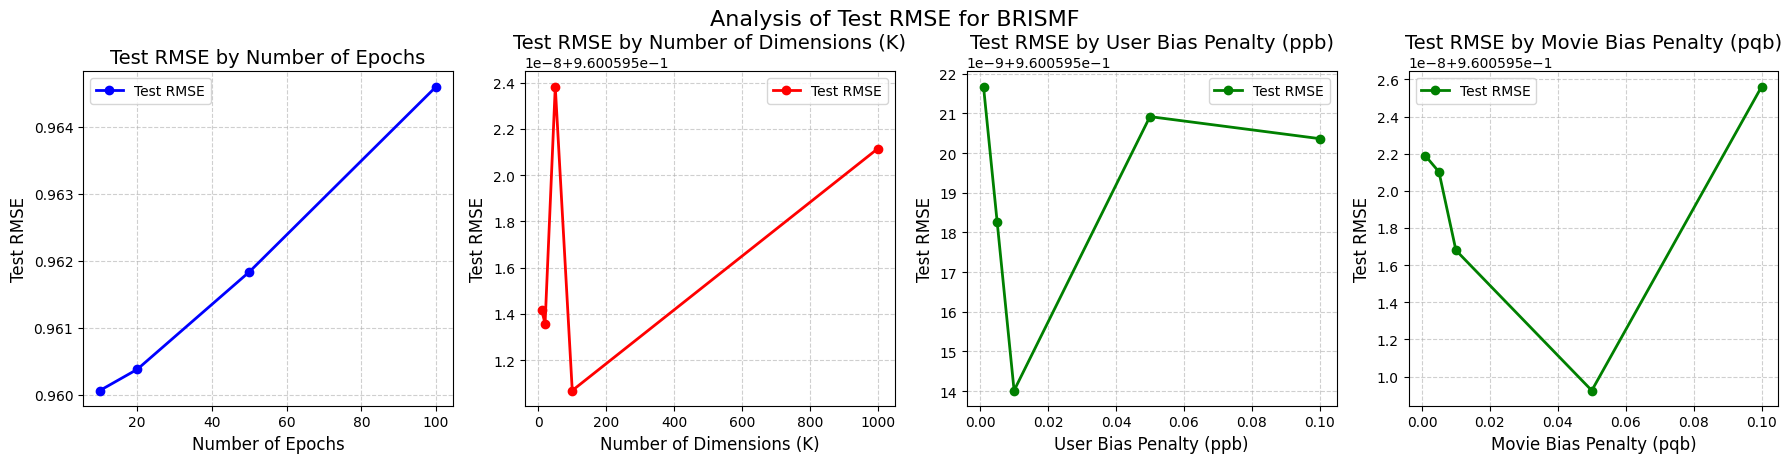

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x1 = epochs_list

# Create a grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 4.5))

# First plot
axes[0].plot(x1, rmse_list_epochs, label='Test RMSE', color='blue', marker='o', linewidth=2)
axes[0].set_title('Test RMSE by Number of Epochs', fontsize=14)
axes[0].set_xlabel('Number of Epochs', fontsize=12)
axes[0].set_ylabel('Test RMSE', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(fontsize=10)

x2 = k_list

# Second plot
axes[1].plot(x2, rmse_list_k, label='Test RMSE', color='red', marker='o', linewidth=2)
axes[1].set_title('Test RMSE by Number of Dimensions (K)', fontsize=14)
axes[1].set_xlabel('Number of Dimensions (K)', fontsize=12)
axes[1].set_ylabel('Test RMSE', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend(fontsize=10)

x3 = p_pb_list

# Third plot
axes[2].plot(x3, rmse_list_p_pb, label='Test RMSE', color='green', marker='o', linewidth=2)
axes[2].set_title('Test RMSE by User Bias Penalty (ppb)', fontsize=14)
axes[2].set_xlabel('User Bias Penalty (ppb)', fontsize=12)
axes[2].set_ylabel('Test RMSE', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].legend(fontsize=10)

x4 = p_qb_list

# Fourth plot
axes[3].plot(x4, rmse_list_p_qb, label='Test RMSE', color='green', marker='o', linewidth=2)
axes[3].set_title('Test RMSE by Movie Bias Penalty (pqb)', fontsize=14)
axes[3].set_xlabel('Movie Bias Penalty (pqb)', fontsize=12)
axes[3].set_ylabel('Test RMSE', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.6)
axes[3].legend(fontsize=10)

# Adjust layout of the plots
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Test RMSE for BRISMF', fontsize=16, y=1.02)

plt.show()